#### ***Imports***

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import euclidean, cityblock, cosine
from collections import Counter, defaultdict

import auxiliarfunctions as af
import knn.knn as neighbors
import numpy as np

#### ***Loading the Datasets***

The datasets used in this notebook are extracted from OpenMl

In [257]:
datasets = []                                        # list of datasets that store tuples X, y
dataCrossVal = []                                    # list of tuples X, y

ids = [37,43465,61,40983,44,59,458,187,54,1464,1491,334] #[37,163,40498,187,41,1527,40983] #,1459
datasets_name = [
                 "Diabetes",                         # list of datasets names
                 "Boston-house-price-data",
                 "Iris",
                 "Wilt",
                 "Spambase",
                 "59",
                 "458",
                 "Wine Quality ",
                 "Vehicle",
                 "Blood-transfusion-service-center",
                 "One-hundred-plants-margin",
                 "Monks-problems-2"
                ]

# Fetch and prepare the datasets
for i in ids:
    datasets.append(af.fetch_and_prepare_dataset(i))


#### ***Visualização dos datasets***

To help visualize the data, we used PCA to reduce the dimensionality of the data to 2D

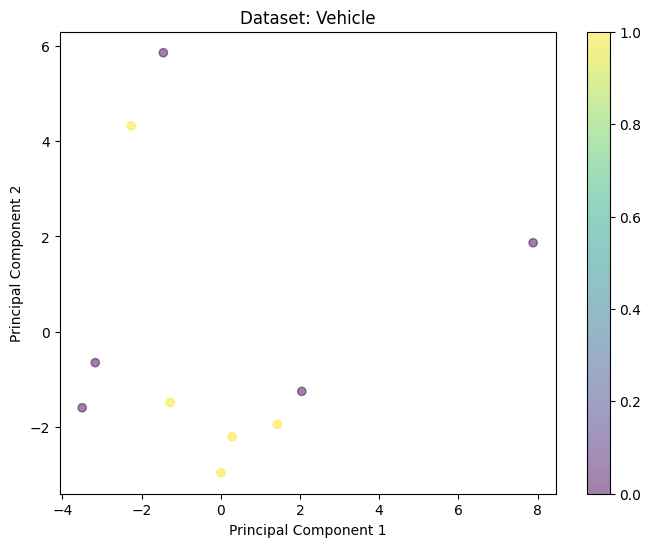

In [258]:
for i in range(len(ids)):
    af.apply_pca_and_plot_with_encoding(datasets[i][0], datasets[i][1],datasets_name[i])

#### ***Modificaçoes do knn***

In [259]:
class BaseEstimatorModified:
    y_required = True
    fit_required = True
    def __init__(self, outlier_detector = None):
        self.outlier_detector = outlier_detector
    

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        #modificaçao
        anomaly_detector = self.outlier_detector
        anomaly_detector.fit(X) 
        
        if hasattr(anomaly_detector, 'negative_outlier_factor_'): # LOF
            weight = anomaly_detector.negative_outlier_factor_
        else:
            weight = anomaly_detector.score_samples(X)

        # -> colocar entre 0 e 1, onde 0 é 100% oulier e 1 é 100% um ponto normal
        if max(weight) == min(weight):
            self.weight = (weight - min(weight))
        else: 
            self.weight = (weight - min(weight)) / (max(weight) - min(weight))

        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()
    

In [260]:
class KNNBaseModified(BaseEstimatorModified):
    def __init__(self, k=5,  outlier_detector = None,distance_func = euclidean):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """
        super().__init__(outlier_detector)
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func
        
    def aggregate(self):
        raise NotImplementedError()

    def _predict(self, X=None):

        predictions = [self._predict_x(x) for x in X]  

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        distances = (self.distance_func(x, example) for example in self.X)

        # agrupa a distancia, target e o peso e depois ordena a lista de forma crescente em relaçao as distancias
        neighbors = sorted(((dist, target,weigth) for (dist, target,weigth) in zip(distances, self.y, self.weight)), key=lambda x: x[0])

        # reduz a lista para conter apenas os k valores mais proximos e modifica a lista para target e peso
        neighbors_targets = [(target,weigth) for (_, target, weigth) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets, self.k)


#### ***Without assigning a value related to the approximation to the new point***

In [261]:
class KNNClassifierWithoutImportance(KNNBaseModified):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets, size):
        """Return the most common target label."""          

        weighted_dict = defaultdict(float)

        for target, weight in neighbors_targets:  
            weighted_dict[target] += weight # value from LOF or IF
            
        weighted_dict = dict(weighted_dict)

        max_target = max(weighted_dict.items(), key=lambda item: item[1])
        
        max_target_key, _ = max_target

        return max_target_key

#### ***Assigning a value related to the approximation to the new point***

In [262]:
class KNNClassifierModefied(KNNBaseModified):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets, size):
        """Return the most common target label."""
        n = size           

        weighted_dict = defaultdict(float)

        for target, weight in neighbors_targets:  
            weighted_dict[target] += ((n*weight)/size) 
            n -= 1
            
        weighted_dict = dict(weighted_dict)

        max_target = max(weighted_dict.items(), key=lambda item: item[1])
        
        max_target_key, _ = max_target

        return max_target_key

#### ***Classification***

The classification is done using the KNN algorithm, we still used the unmofied version of the algorithm to classify the data so we can have a baseline to compare the results with. We also use the assignment of a weight related to the approximation of the points to the new data point to compare whether this method improves the result or not.

In [263]:
classifiers = [Pipeline([('classifier', neighbors.KNNClassifier(k=5))]),
               Pipeline([('classifier', KNNClassifierWithoutImportance(k=5, outlier_detector = IsolationForest(contamination=0.1)))]),
               Pipeline([('classifier', KNNClassifierWithoutImportance(k=5, outlier_detector = LocalOutlierFactor(n_neighbors=20)))]),
               Pipeline([('classifier', KNNClassifierModefied(k=5, outlier_detector = IsolationForest(contamination=0.1)))]),
               Pipeline([('classifier', KNNClassifierModefied(k=5, outlier_detector = LocalOutlierFactor(n_neighbors=20)))])
               ]
classifiers_names = ['KNN', 'KNN Modified with Isolation Forest without importance', 'KNN Modified with Local Outlier Factor without importance', 'KNN Modified with Isolation Forest', 'KNN Modified with Local Outlier Factor']



In [264]:
kf_5 = KFold(n_splits=5, shuffle=True, random_state=1)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

In [265]:
def perform_cross_validation(classifier, X, y):
    scores_5 = cross_val_score(classifier, X, y, cv=kf_5, scoring='accuracy')
    scores_10 = cross_val_score(classifier, X, y, cv=kf_10, scoring='accuracy')

    return np.mean(scores_5), np.mean(scores_10)

#### ***Results***

In [266]:
for i in range(len(datasets)):
    print(f'Accuracy for dataset {datasets_name[i]}:')
    for classifier, classifier_name in zip(classifiers, classifiers_names):
        accuracy_5, accuracy_10  = perform_cross_validation(classifier, datasets[i][0], datasets[i][1])
        print(f'- classifier {classifier_name} with 5 splits: {accuracy_5}')
        print(f'- classifier {classifier_name} with 10 splits: {accuracy_10}')

Accuracy for dataset Vehicle:
- classifier KNN with 5 splits: 0.4
- classifier KNN with 10 splits: 0.4
- classifier KNN Modified with Isolation Forest without importance with 5 splits: 0.4
- classifier KNN Modified with Isolation Forest without importance with 10 splits: 0.5
- classifier KNN Modified with Local Outlier Factor without importance with 5 splits: 0.4
- classifier KNN Modified with Local Outlier Factor without importance with 10 splits: 0.4
- classifier KNN Modified with Isolation Forest with 5 splits: 0.4
- classifier KNN Modified with Isolation Forest with 10 splits: 0.5
- classifier KNN Modified with Local Outlier Factor with 5 splits: 0.4
- classifier KNN Modified with Local Outlier Factor with 10 splits: 0.4
